## Decision trees
A decision tree is a "decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility [1]. In machine learning, a tree can be used to visually and explicitly represent decisions and decision making, describing data according to a set of rules made on every node of the tree. The tree divides the observations used to build (train) the model and very leaf has a group of observations.

In this notebook we're using the home prices using dataset from Melbourne, Australia. _Categorical values will not be considered._

(Inspired by a tutorial published at www.kaggle.com)

[1] https://en.wikipedia.org/wiki/Decision_tree

### 1. Loading dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

df_housing = pd.read_csv('data/melb_data.csv', index_col=0)
df_housing = df_housing.select_dtypes(exclude=['object']) # Keep just numeric columns (not using objects right now)
df_housing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,18396.000000,1.839600e+04,18395.000000,18395.000000,14927.000000,14925.000000,14820.000000,13603.000000,7762.000000,8958.000000,15064.000000,15064.000000,18395.000000
mean,2.935040,1.056697e+06,10.389986,3107.140147,2.913043,1.538492,1.615520,558.116371,151.220219,1965.879996,-37.809849,144.996338,7517.975265
std,0.958202,6.419217e+05,6.009050,95.000995,0.964641,0.689311,0.955916,3987.326586,519.188596,37.013261,0.081152,0.106375,4488.416599
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.330000e+05,6.300000,3046.000000,2.000000,1.000000,1.000000,176.500000,93.000000,1950.000000,-37.858100,144.931193,4294.000000
50%,3.000000,8.800000e+05,9.700000,3085.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.803625,145.000920,6567.000000
75%,3.000000,1.302000e+06,13.300000,3149.000000,3.000000,2.000000,2.000000,651.000000,174.000000,2000.000000,-37.756270,145.060000,10331.000000
max,12.000000,9.000000e+06,48.100000,3978.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


### 2. Preliminary tests with DecisionTree and RandomForest
In these preliminary tests we drop lines with NaN values and try a DecisionTreeRegressor and a RandomForestRegressor.

In [2]:
# Count of columns with NaN values
print("Number of NaN values \n{}".format(df_housing.isnull().sum()))

# Dropping NaN values
df = df_housing.dropna(axis=0) # axis = 0 means we're looking on indexes (rows)
print("Number of valid observations = {}".format(df.shape[0]))

# Loading predictors and target (X/y) 
predictors = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']
X = df[predictors]
y = df.Price

Number of NaN values 
Rooms                0
Price                0
Distance             1
Postcode             1
Bedroom2          3469
Bathroom          3471
Car               3576
Landsize          4793
BuildingArea     10634
YearBuilt         9438
Lattitude         3332
Longtitude        3332
Propertycount        1
dtype: int64
Number of valid observations = 6830


In [3]:
# Split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# call this method
# Creating training/testing sets (75/25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("train_size={} test_size={}".format(len(X_train), len(X_test)))

train_size=5122 test_size=1708


In [4]:
# Now training a simple linear regression classifier
classifier = DecisionTreeRegressor()
classifier.fit(X_train, y_train)

print("Using a DecisionTree and dropping columns with Missing Values:")
print("Accuracy \t= {0:.2f}%".format(classifier.score(X_test, y_test)*100))
print("MEA \t\t= {0:,.0f}".format(mean_absolute_error(y_test, classifier.predict(X_test))))

Using a DecisionTree and dropping columns with Missing Values:
Accuracy 	= 63.99%
MEA 		= 247,707


In [5]:
# Function to check performance of the tree regressor based on the number of leaves
def get_mae(max_leaf_nodes, predictors_train, predictors_val, targ_train, targ_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(predictors_train, targ_train)
    preds_val = model.predict(predictors_val)
    mae = mean_absolute_error(targ_val, preds_val)
    return(mae)

# compare MAE with differing values of max_leaf_nodes
for number_of_leaves in [5, 50, 500, 5000]:
    mae = get_mae(number_of_leaves, X_train, X_test, y_train, y_test)
    print("Max leaf nodes: {0:.0f}  \t\t Mean Absolute Error:  {1:,.0f}".format(number_of_leaves, mae))

Max leaf nodes: 5  		 Mean Absolute Error:  341,963
Max leaf nodes: 50  		 Mean Absolute Error:  260,332
Max leaf nodes: 500  		 Mean Absolute Error:  232,946
Max leaf nodes: 5000  		 Mean Absolute Error:  245,789


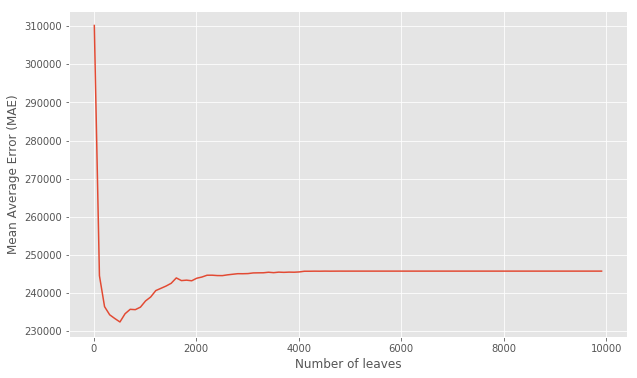

In [6]:
# Now plot a graph of MAE vs. number of leaves
max_leaf_nodes = range(10,10000,100)
mae_list = [get_mae(number_of_leaves, X_train, X_test, y_train, y_test) for number_of_leaves in max_leaf_nodes]

plt.clf()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(max_leaf_nodes, mae_list)
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Mean Average Error (MAE)')
plt.show()

In [7]:
# Now trying a more sophisticated model, the random forest regressor
# The random forest uses many trees, and it makes a prediction by averaging the 
# predictions of each component tree. It generally has much better predictive accuracy 
# than a single decision tree and it works well with default parameters.
forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(X_train, y_train)

# Checking the confidence of the model we just trained
print("Accuracy \t= {0:.2f}%".format(forest_model.score(X_test, y_test)*100))
print("MEA \t\t= {0:,.0f}".format(mean_absolute_error(y_test, forest_model.predict(X_test))))

Accuracy 	= 77.43%
MEA 		= 194,140


### 3. Trying some different configurations using RandomForest
Now we try some different feature sets:
- Removing columns with NaN values
- Using Imputer to fill missing values with the mean
- Making a copy of columns with missing values to avoid changing original data (while Imputing)

In [8]:
# Function to measure approach (returns MAE and Accuracy)
def score_dataset(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds), model.score(X_test, y_test)

In [9]:
# Loading features and label (X/y) 
X = df_housing.drop('Price', axis=1)
y = df_housing['Price']

In [10]:
# Model 1 - Removing columns with NaN values
# Note: After removing the columns with NaN values the only feature left will be 'Rooms'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
X_train = X_train.drop(cols_with_missing, axis=1)
X_test  = X_test.drop(cols_with_missing, axis=1)
mea, accuracy = score_dataset(X_train, X_test, y_train, y_test)
print("Dropping columns with Missing Values:")
print("Accuracy \t= {0:.2f}%".format(accuracy*100))
print("MEA \t\t= {0:,.0f}".format(mea))

Dropping columns with Missing Values:
Accuracy 	= 22.26%
MEA 		= 389,262


In [11]:
# Model 2 - Using Imputer to fill missing values with the mean
my_imputer = Imputer()
X_new = pd.DataFrame(my_imputer.fit_transform(X)) # applying mean on all X matrix (!)
X_new.columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=0)

mea, accuracy = score_dataset(X_train, X_test, y_train, y_test)
print("Using Imputation (w/ mean):")
print("Accuracy \t= {0:.2f}%".format(accuracy*100))
print("MEA \t\t= {0:,.0f}".format(mea))

Using Imputation (w/ mean):
Accuracy 	= 71.70%
MEA 		= 197,030


In [12]:
# Model 3 - Making a copy of columns with missing values to avoid changing original data (while Imputing)
cols_with_missing = (col for col in X.columns 
                                 if X[col].isnull().any())
X_copy = X.copy()
for col in cols_with_missing:
    X_copy[col + '_was_missing'] = X_copy[col].isnull()

# Imputation - applying mean on all X matrix 
my_imputer = Imputer()
X_new = pd.DataFrame(my_imputer.fit_transform(X_copy))
X_new.columns = X_copy.columns

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=0)

mea, accuracy = score_dataset(X_train, X_test, y_train, y_test)

print("Making a copy of columns with missing values before Imputation:")
print("Accuracy \t= {0:.2f}%".format(accuracy*100))
print("MEA \t\t= {0:,.0f}".format(mea))

Making a copy of columns with missing values before Imputation:
Accuracy 	= 71.65%
MEA 		= 196,786
